# Neural Network from Scratch

In this notebook I will manually build a neural network
architecture that is like Tensorflow API.

Before starting I will review some OOP concepts that 
become handy later on.

## Class and Methods

In [167]:
class SimpleClass():  # Class declaration
    def __init__(self):  # Method declaration
        print("hello from simple class")
        
    def shout(self):
        print("Shouting from simple class")
        

class inherited_class(SimpleClass): # Inheritance
    def __init__(self):
        print("In inherited class") # inherited_class has it's own __init__ method
                                    # but inherit the shout method from simple class

c = inherited_class()

In inherited class


Now lets inherit the __init__ method from SimpleClass as well

In [168]:
class inherited_class(SimpleClass):
    def __init__(self):
        super().__init__()

c = inherited_class()
c.shout()

hello from simple class
Shouting from simple class


## Operation

In [169]:
class Operation():
    """
    An Operation is a node in a "Graph". TensorFlow will also use this concept of a Graph.
    
    This Operation class will be inherited by other classes that actually compute the specific
    operation, such as adding or matrix multiplication.
    """
    
    def __init__(self, input_nodes = []):
        """
        Intialize an Operation
        """
        self.input_nodes = input_nodes # The list of input nodes
        self.output_nodes = [] # List of nodes consuming this node's output
        
        # For every node in the input, we append this operation (self) to the list of
        # the consumers of the input nodes
        for node in input_nodes:
            node.output_nodes.append(self)
        
        # There will be a global default graph (TensorFlow works this way)
        # We will then append this particular operation
        # Append this operation to the list of operations in the currently active default graph
        _default_graph.operations.append(self)
  
    def compute(self):
        """ 
        This is a placeholder function. It will be overwritten by the actual specific operation
        that inherits from this class.
        
        """
        
        pass

Now let's create Addition, Multiplication and Matrix Multiplication

### Addition

In [170]:
class add(Operation):
    
    def __init__(self, x, y):
         
        super().__init__([x, y])

    def compute(self, x_var, y_var):
         
        self.inputs = [x_var, y_var]
        return x_var + y_var

### Multiplication

In [171]:
class multiply(Operation):
     
    def __init__(self, a, b):
        
        super().__init__([a, b])
    
    def compute(self, a_var, b_var):
         
        self.inputs = [a_var, b_var]
        return a_var * b_var

### Matrix Multiplication

In [172]:
class matmul(Operation):
     
    def __init__(self, a, b):
        
        super().__init__([a, b])
    
    def compute(self, a_mat, b_mat):
         
        self.inputs = [a_mat, b_mat]
        return a_mat.dot(b_mat)

## Placeholders (Node)

are empty node that needs a value to be provided 
to compute output

In [173]:
class Placeholder():
    """
    A placeholder is a node that needs to be provided a value for computing the output in the Graph.
    """
    
    def __init__(self):
        
        self.output_nodes = []
        
        _default_graph.placeholders.append(self)

## Variables (Weight)

In [174]:
class Variable():
    """
    This variable is a changeable parameter of the Graph.
    """
    
    def __init__(self, initial_value = None):
        
        self.value = initial_value
        self.output_nodes = []
        
         
        _default_graph.variables.append(self)

## Graph

is a Global variable connecting variables and placeholders to operations

In [175]:
class Graph():
    
    
    def __init__(self):
        
        self.operations = []
        self.placeholders = []
        self.variables = []
        
    def set_as_default(self):
        """
        Sets this Graph instance as the Global Default Graph
        """
        global _default_graph
        _default_graph = self

## Now lets make a simple graph

$$ z = Ax + b $$

With A=10 and b=1

$$ z = 10x + 1 $$

Just need a placeholder for x and then once x is filled in we can solve it!

Here x is a placeholder and two operations (addition,multiplication) are involved

In [176]:
g = Graph()

In [177]:
g.set_as_default()

In [178]:
A = Variable(10)

In [179]:
b = Variable(1)

In [180]:
x = Placeholder()

In [181]:
y = multiply(A,x)

In [182]:
z = add(y,b)

Now we need to actually get the nodes and traverse the graph

### Traversing Operation Nodes

In [183]:
import numpy as np

In [184]:
def traverse_postorder(operation):
    """ 
    PostOrder Traversal of Nodes. Basically makes sure computations are done in 
    the correct order (Ax first , then Ax + b). 
    """
    
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder

Now we create a session class 

In [185]:
class Session():
    
    def run(self, operation, feed_dict = {}):
        """ 
          operation: The operation to compute
          feed_dict: Dictionary mapping placeholders to input values (the data)  
        """
        
        # Puts nodes in correct order
        nodes_postorder = traverse_postorder(operation)
        
        for node in nodes_postorder:

            if type(node) == Placeholder:
                
                node.output = feed_dict[node]
                
            elif type(node) == Variable:
                
                node.output = node.value
                
            else: # Operation
                
                node.inputs = [input_node.output for input_node in node.input_nodes]

                 
                node.output = node.compute(*node.inputs) # * since we don't know how many input we will have
                
            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)
        
        # Return the requested node value
        return operation.output




Now finally we can implement our simple graph

In [186]:
sess = Session()
result = sess.run(operation=z,feed_dict={x:10})
result

101

Now lets deal with matrix

In [187]:
g = Graph()
g.set_as_default()
A = Variable([[1,5],[2,3]])
b = Variable([2,9])
x = Placeholder()
y = matmul(A,x)
z = add(y,b)

In [188]:
sess = Session()
result = sess.run(operation=z,feed_dict={x:5})
result

array([[ 7, 34],
       [12, 24]])

Now with our neural network infrastructure taken care of
let's  do a classification task

But first of all lets introduce activation functions

### Activation Function

In [190]:
import matplotlib.pyplot as plt
%matplotlib inline

#### sigmoid function

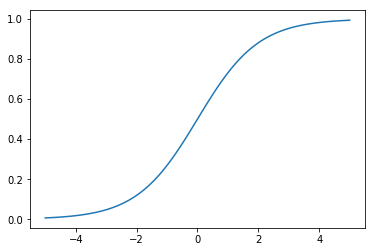

In [191]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

x = np.linspace(-5,5,100)
y = sigmoid(x)

plt.plot(x,y)

Let's define sigmoid as an operation

In [192]:
class Sigmoid(Operation):
    def __init__(self,z):
        super().__init__([z])
        
    def compute(self,z_value):
        return 1/(1+np.exp(-z_value))

Now let's make some data for our classification problem

In [193]:
from sklearn.datasets import make_blobs
data = make_blobs(n_samples=100,n_features = 2,centers=2,random_state=1)

In [195]:
data

(array([[-7.94152277e-01,  2.10495117e+00],
        [-9.15155186e+00, -4.81286449e+00],
        [-3.10367371e+00,  3.90202401e+00],
        [-1.42946517e+00,  5.16850105e+00],
        [-7.46938680e+00, -4.20198333e+00],
        [-9.19585147e+00, -3.90678125e+00],
        [-9.31764266e+00, -4.27315015e+00],
        [-9.20490564e+00, -4.57687928e+00],
        [-2.76017908e+00,  5.55121358e+00],
        [-1.17104176e+00,  4.33091816e+00],
        [-1.00364080e+01, -5.56912090e+00],
        [-1.53773863e+00,  5.53597378e+00],
        [-1.01081595e+01, -4.57071061e+00],
        [-2.40671820e+00,  6.09894447e+00],
        [-7.80701277e+00, -5.84970947e+00],
        [-9.01137732e+00, -3.73981465e+00],
        [-9.76521794e+00, -3.27079714e+00],
        [-2.34673261e+00,  3.56128423e+00],
        [-2.00341358e+00,  4.45008673e+00],
        [-1.10926243e+01, -3.78396611e+00],
        [-9.43495141e+00, -3.71261146e+00],
        [-1.02639310e+01, -3.92073400e+00],
        [-9.74891334e+00, -4.249

lets construct features and target

In [196]:
features = data[0]
target = data[1]

Lets visualize the feature set and color them by target

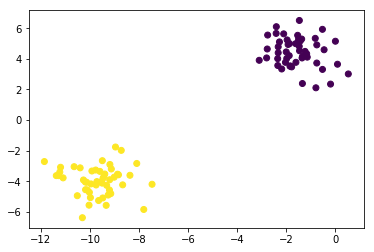

In [200]:
plt.scatter(features[:,0],features[:,1],c=target)

Lets manually draw a line to separate the data

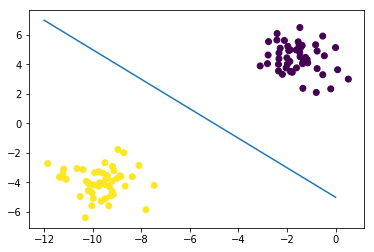

In [203]:
x = np.linspace(-12,0,10)
y = -x -5
plt.scatter(features[:,0],features[:,1],c=target)
plt.plot(x,y)

Now Lets define our perceptron using matrix representation of featuers

## Defining the Perceptron

$$ y = mx + b $$

$$ y = -x - 5 $$

$$ f1 = mf2 + b , m=1$$

$$ f1 = -f2 + 5 $$

$$ f1 + f2 - 5 = 0 $$

Basically here, f1 is feature 1 which is **x** and f2 is feature 2 which is **y**

### Convert to a Matrix Representation of Features

$$ w^Tx + b = 0 $$

$$   \Big(1, 1\Big)f - 5 = 0 $$

Then if the result is > 0 its target 1, if it is less than 0, it is target=0

### Example Point

Let's say we have the point f1=2 , f2=2 otherwise stated as (2,2). Then we have:

$$ 
\begin{pmatrix} 
1 , 1
\end{pmatrix} 
\begin{pmatrix} 
2 \\
2
\end{pmatrix} - 5 =  $$

In [206]:
np.array([1,1]).dot(np.array([2,2])) - 5

-1

Which is correctly specified as target = 0

Or if we have point (0,6)

In [207]:
np.array([1,1]).dot(np.array([0,6])) - 5

1

it is correctly specified as target = 1

## Now lets do this using our simple neural network

In [208]:
g = Graph()

In [209]:
g.set_as_default()

In [210]:
x =Placeholder()

In [211]:
w = Variable([1,1])


In [212]:
b = Variable(-5)

In [213]:
z = add(matmul(w,x),b)

In [214]:
a = Sigmoid(z)

In [216]:
sess = Session()
sess.run(operation=a,feed_dict={x:[2,2]})


0.2689414213699951

This number illustrate the probability of point (1,1)
being labeled as 1 since it is low we label this point as 0

In [217]:
sess.run(operation=a,feed_dict={x:[0,6]})

0.7310585786300049

Same as above